In [2]:
%pylab inline
%load_ext autoreload

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pandas as pd
import numpy as np
import scipy as spy
import os
import copy
import pickle
import itertools
from functools import lru_cache

from glob import glob

import matplotlib.ticker as ticker
import seaborn as sns
import matplotlib.patches as mpatches
from collections import Counter, defaultdict
from itertools import combinations

from tqdm import tqdm_notebook
import collections, functools, operator 
from bidict import bidict
from multiprocessing import Pool

import sys
from casadi import *
sys.path.append('../../../')
import do_mpc
import pickle

from tqdm import tqdm

sys.path.append('./')
from libMPC import *

# Def Parameter

In [6]:
pwd

'/home/students/s277665/Vaccini/gitHub'

In [9]:
parCalibration = pickle.load(open("./data/resCalibration/calibrationFinalW001v2", "rb" ))  
parCalibration

{'betaL': 0.45686001080419,
 'betaH': 0.7991490461149616,
 'gamma': 2.045714285714286,
 'gamma2': 2.7391361785112527,
 'alpha': 35.770162994195054,
 'lambd': 8.217408535533758,
 'K': 0.001,
 'I0': 65861.61906762236,
 'S0': 1,
 'thH': 20320.100749070727,
 'H0': 1686.2857142857142,
 'D0': 35520.0}

# Define function for plot

In [10]:
def plotOneLine(ax, y, x=None, label="", c="C1", offSetX=0, dots=True, marker="o"):
    if x is None: x = np.arange(offSetX, len(y)+offSetX)
        
    if dots:  
        ax.plot(x, y, marker+'-', linewidth=1.5, color=c, markersize=2.9, markerfacecolor='w')
        ax.plot(np.NaN, np.NaN, marker+'-', linewidth=1.5, label=label, color=c, markersize=4, markerfacecolor='w')
    else:  
        ax.plot(x, y, linewidth=1.5, label=label, color=c)

# Def function for simulations

In [11]:
def runNoControl(par, Dw="2w"):
    '''
    run the simulator without control 
    x0 is set at the week of 21--28 December
    '''
    
    model = getModel(par, Dw=Dw)
    simulator = getSimulator(model, par)
    simulator.x0 = getX0At2712(par)
    
    for k in range(par.timeSimulation):
        y_next = simulator.make_step(np.zeros((2,1)))

    return simulator


def runNoControlFromSept(par, Dw="2w", steps=16):
    '''
    run the simulator without control 
    x0 is set at the week of 1 September
    '''
    
    model = getModel(par, Dw=Dw)
    simulator = getSimulator(model, par)
    simulator.x0 = getX0(par)
    
    for k in range(steps):
        y_next = simulator.make_step(np.zeros((2,1)))

    return simulator


def runFirstControl(par, Dw="2w"):
    '''
    run the simulator using the fixed strategy: First doses only
    x0 is set at the week of 21--28 December
    '''
        
    model = getModel(par, Dw=Dw)
    simulator = getSimulator(model, par)
    simulator.x0 = getX0At2712(par)
    
    simulatorII = getSimulator(model, par)
    simulatorII.x0 = getX0At2712(par)
    
    for k in range(par.timeSimulation):
        #simulate one step without control, than take the reamining doses to create the control
        y_nextII = simulatorII.make_step(np.zeros((2,1)))
        uk = np.array([[y_nextII[11][0]], [0]])    
        
        y_next = simulator.make_step(uk)
        simulatorII.x0 = y_next
        
    return simulator  


def runAltControl(par, Dw="2w"):
    '''
    run the simulator using the fixed strategy: Alternating strategy
    x0 is set at the week of 21--28 December
    '''
        
    model = getModel(par, Dw=Dw)
    simulator = getSimulator(model, par)
    simulator.x0 = getX0At2712(par)
    
    simulatorII = getSimulator(model, par)
    simulatorII.x0 = getX0At2712(par)
    
    for k in range(par.timeSimulation):
        #simulate one step without control, than take the reamining doses and W to create the control
        y_nextII = simulatorII.make_step(np.zeros((2,1)))
        u2 = y_nextII[9][0]
        u1 = y_nextII[11][0] - u2        
        uk = np.array([[u1], [u2]])
        
        y_next = simulator.make_step(uk)
        simulatorII.x0 = y_next
    
    return simulator


def _runAltControlFromX0(par, horizon, x0, Dw):
    '''
    run the simulator using the fixed strategy: Alternating strategy
    x0 is user provided
    The time of the simulation is set by horizon parameter
    return the control for the Alternating strategy
    '''
    model = getModel(par, Dw=Dw)
    simulator = getSimulator(model, par)
    simulator.x0 = x0
    
    simulatorII = getSimulator(model, par)
    simulatorII.x0 = x0
        
    for k in range(horizon):    
        y_nextII = simulatorII.make_step(np.zeros((2,1)))
        u2 = y_nextII[9][0]
        u1 = y_nextII[11][0] - u2        
        uk = np.array([[u1], [u2]])
        
        y_next = simulator.make_step(uk)
        simulatorII.x0 = y_next
    
    return getData(simulator)[2].to_numpy()


def runMPC(par, n_horizon=15, Dw="2w"):
    '''
    run the simulator using the MPC control
    x0 is set at the week of 21--28 December
    '''
 
    model = getModel(par, Dw=Dw)
    simulator = getSimulator(model, par)
    mpc = getMPC(model, par, n_horizon=n_horizon)

    # set initial condition
    x0 = getX0At2712(par)
    simulator.x0 = x0
    mpc.x0 = x0
    mpc.u0 = np.zeros((2,1))
    mpc.set_initial_guess()

    
    for k in tqdm(range(par.timeSimulation)):
        # make one step
        u0 = mpc.make_step(x0)
        x0 = simulator.make_step(u0)
          
    return simulator

# One MPC

In [12]:
def getMPC(model, par, n_horizon=19):
    '''
    get the MPC class
    '''
    #Reads
    betaH, betaL, K, thHH = par.betaH, par.betaL, par.K, par.thH
    alpha, lambd, gamma, gamma2, I0_par, S0_par, H0_par, D0_par = 1/par.alpha, 1/par.lambd, 1/par.gamma, 1/par.gamma2, par.I0, par.S0, par.H0, par.D0

    supplyNumber, timeSimulation, supplyNumber = par.supplyNumber, par.timeSimulation, par.supplyNumber 
    alphaVacc,sigmaVacc,N = par.alphaVacc ,par.sigmaVacc ,par.N 
    
    
    #Build the model
    mpc = do_mpc.controller.MPC(model)
    setup_mpc = {
        'n_robust': 0,
        'n_horizon': n_horizon,
        't_step': 1,
        'state_discretization': 'discrete',
        'store_full_solution':False,
        'open_loop': 0,
        'nlpsol_opts': {'ipopt.print_level':0, 'ipopt.sb': 'yes', 'print_time':0, "ipopt.tol":1e-8, "ipopt.acceptable_tol":1e-7, "ipopt.max_iter":50_000}
    }
    mpc.set_param(**setup_mpc)
    
    
    #Bounds
    mpc.bounds['lower','_u','u1'] = 0.0
    mpc.bounds['lower','_u','u2'] = 0.0
    mpc.bounds['lower','_x','S'] = 0.0
    mpc.bounds['lower','_x','W'] = 0.0
    mpc.bounds['lower','_x','rema'] = 0.0

    
    #Objective
    lterm = (model.x['H'] / par.WH)**2 + ((par.betaH - model.x['beta'])/par.WBeta)**2
    mterm = lterm
    mpc.set_objective(lterm=lterm, mterm=mterm) 
    
    #Constrains
    mpc.set_nl_cons("constrain", model.u["u1"] + model.u["u2"], ub=par.supplyWeekLim);
    
    mpc.setup()
    return mpc

In [7]:
parExtra = {
    "alphaVacc":1/12, 
    "sigmaVacc":0.76, 
    "timeSimulation":52,
    "supplyNumber": 1_000_000,
}
Dw = "3w"
par = parameters(parCalibration, parExtra)

simulatorFisrtASZ = runFirstControl(par, Dw=Dw)
simulatorNoCASZ = runNoControl(par, Dw=Dw)
simulatorAltASZ = runAltControl(par, Dw=Dw)
simulatorMPCASZ = runMPC(par, n_horizon=15, Dw=Dw)

/home/students/s277665/.conda/envs/mpc/lib/python3.7/site-packages/do_mpc/controller.py:751: UserWarning: rterm was not set and defaults to zero. Changes in the control inputs are not penalized. Can lead to oscillatory behavior.
  warnings.warn('rterm was not set and defaults to zero. Changes in the control inputs are not penalized. Can lead to oscillatory behavior.')
100%|██████████| 52/52 [00:02<00:00, 22.09it/s]


In [8]:
parExtra = {
    "alphaVacc":1/12, 
    "sigmaVacc":0.52, 
    "timeSimulation":52,
    "supplyNumber": 1_000_000,
}
Dw = "2w"
par = parameters(parCalibration, parExtra)

simulatorFisrtPFZ = runFirstControl(par, Dw=Dw)
simulatorNoCPFZ = runNoControl(par, Dw=Dw)
simulatorAltPFZ = runAltControl(par, Dw=Dw)
simulatorMPCPFZ = runMPC(par, n_horizon=15, Dw=Dw)

100%|██████████| 52/52 [00:02<00:00, 23.42it/s]


In [9]:
def plotFig1(dataMPC, dataNoC, dataFisrt, dataAlt, name):
    dataPre = getData(runNoControlFromSept(par))

    nRow=2
    hspace=0.25
    hRow=1.1

    fig, ax = plt.subplots(nRow, sharex=True, figsize=(5,nRow*hRow + ((nRow-1)*hspace*hRow)), dpi=80)
    plt.subplots_adjust(hspace=hspace)

    #plotOneLine(ax[0], dataPre[0].H, c="grey", dots=False, offSetX=-15)
    plotOneLine(ax[0], dataNoC[0].H, label="no control", c="C0", offSetX=0)
    plotOneLine(ax[0], dataMPC[0].H, label="MPC", c="C1", offSetX=0)

    #plotOneLine(ax[1], dataPre[0].beta, c="grey", dots=False, offSetX=-15)
    plotOneLine(ax[1], dataNoC[0].beta, c="C0", offSetX=0)
    plotOneLine(ax[1], dataMPC[0].beta, c="C1", offSetX=0)

    ax[0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax[0].legend(loc='upper right', bbox_to_anchor=(1.0, 1.45), ncol=2, fancybox=True)
    ax[0].set_ylabel("H")
    ax[1].set_ylabel(r"$\beta$")
    ax[1].set_xlabel(r"weeks")
    
    ax[-1].set_xticks([tick for tick in plt.gca().get_xticks() if tick >=0])

    for _ax in ax: _ax.yaxis.set_label_coords(-0.1, 0.5)
    for _ax in ax: _ax.set_xlim(-3, 55)

    plt.savefig(f"./FIG/oneMPC_1_{name}.pdf", bbox_inches="tight")




    nRow=3
    fig, ax = plt.subplots(nRow, sharex=True, figsize=(5,nRow*hRow + ((nRow-1)*hspace*hRow)), dpi=80)
    plt.subplots_adjust(hspace=hspace)

    #plotOneLine(ax[0], dataPre[2]["second dose"], c="grey", dots=False, offSetX=-15)
    plotOneLine(ax[0], dataMPC[2]["first dose"], label="first dose", c="limegreen", offSetX=0)
    plotOneLine(ax[0], dataMPC[2]["second dose"], label="second dose", c="C3", offSetX=0)

    #plotOneLine(ax[1], dataPre[0].W, c="grey", dots=False, offSetX=-15)
    plotOneLine(ax[1], dataMPC[0].W, c="C1", offSetX=0)
    #plotOneLine(ax[2], dataPre[0].V, c="grey", dots=False, offSetX=-15)
    plotOneLine(ax[2], dataMPC[0].V, c="C1", offSetX=0)

    ax[0].legend(loc='upper right', bbox_to_anchor=(1.0, 1.45), ncol=2, fancybox=True)
    ax[0].set_ylabel("doses")
    ax[1].set_ylabel(r"W")
    ax[2].set_ylabel(r"V")
    ax[-1].set_xlabel(r"weeks")
    ax[-1].set_xticks([tick for tick in plt.gca().get_xticks() if tick >=0])

    for _ax in ax: _ax.set_xlim(-3, 55)
    for _ax in ax: _ax.yaxis.set_label_coords(-0.1, 0.5)
    for _ax in ax: _ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    plt.savefig(f"./FIG/oneMPC_2_{name}.pdf", bbox_inches="tight")
    
    print(f"Fisrt costs: {computeCost(dataFisrt, par)}"); print(f"Alt costs: {computeCost(dataAlt, par)}"); print(f"MPC costs: {computeCost(dataMPC, par)}")

Fisrt costs: (13.86397777212886, 16.620519952073884, 30.484497724202754)
Alt costs: (10.859718523954573, 12.884573321629736, 23.744291845584318)
MPC costs: (11.27489154269459, 12.88313342147261, 24.158024964167204)


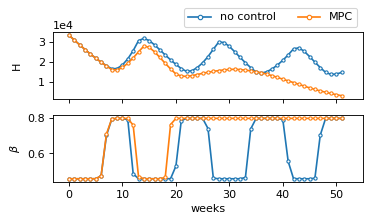

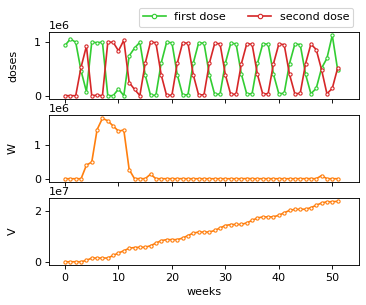

In [10]:
plotFig1(getData(simulatorMPCASZ), getData(simulatorNoCASZ), getData(simulatorFisrtASZ), getData(simulatorAltASZ), "ARZ")

Fisrt costs: (15.72577949571208, 21.466051919981627, 37.19183141569369)
Alt costs: (10.572310569343278, 12.791248117420189, 23.36355868676347)
MPC costs: (10.637998667541144, 12.797517463377396, 23.43551613091855)


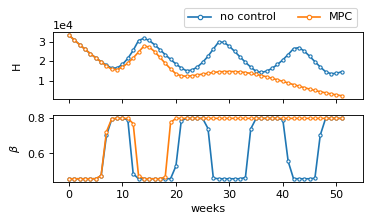

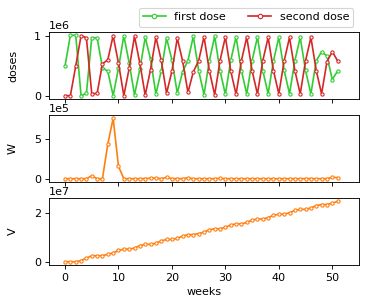

In [11]:
plotFig1(getData(simulatorMPCPFZ), getData(simulatorNoCPFZ), getData(simulatorFisrtPFZ), getData(simulatorAltPFZ), "PFZ")

In [54]:
# percentace of population in V at week 20
getData(simulatorMPCASZ)[0].V[20]/ getData(simulatorMPCASZ)[0][["S", "I", "R", "H", "D", "F1", "F2", "F3", "W"]].sum(1)[20]

0.1754984349958313

# The 3 cases Alt, Not quite, NO

In [12]:
alpha1 = 1/6
alpha2 = 1/18
alpha3 = 1/24

In [13]:
def getExpWithAlpha(alpha):
    parExtra = {
        "alphaVacc":alpha, 
        "sigmaVacc":0.76, 
        "timeSimulation":52,
        "supplyNumber": 1_000_000,
    }
    Dw = "3w"
    par = parameters(parCalibration, parExtra)
    
    simulatorMPC = runMPC(par, n_horizon=15, Dw=Dw)
    simulatorFirstOnly = runFirstControl(par, Dw=Dw)
    simulatorAlt = runAltControl(par, Dw=Dw)

    return simulatorMPC,simulatorFirstOnly,simulatorAlt

exp1,exp1FO,exp1Alt = getExpWithAlpha(alpha1)
exp2,exp2FO,exp2Alt = getExpWithAlpha(alpha2)
exp3,exp3FO,exp3Alt = getExpWithAlpha(alpha3)

/home/students/s277665/.conda/envs/mpc/lib/python3.7/site-packages/do_mpc/controller.py:751: UserWarning: rterm was not set and defaults to zero. Changes in the control inputs are not penalized. Can lead to oscillatory behavior.
  warnings.warn('rterm was not set and defaults to zero. Changes in the control inputs are not penalized. Can lead to oscillatory behavior.')
100%|██████████| 52/52 [00:02<00:00, 18.72it/s]


In [14]:
exp1,exp1FO,exp1Alt = getData(exp1),getData(exp1FO),getData(exp1Alt)
exp2,exp2FO,exp2Alt = getData(exp2),getData(exp2FO),getData(exp2Alt)
exp3,exp3FO,exp3Alt = getData(exp3),getData(exp3FO),getData(exp3Alt)

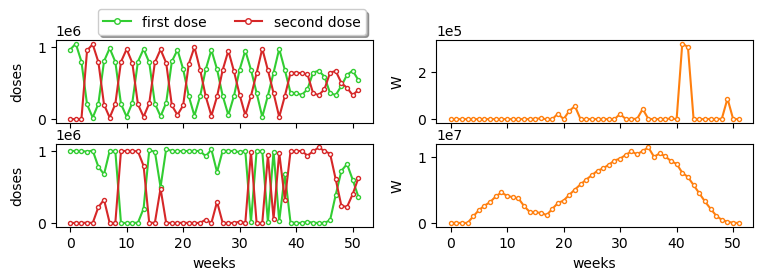

In [20]:
nRow=2
hspace=0.25
hRow=1.1

fig, ax = plt.subplots(nRow, 2, sharex=True, figsize=(9,nRow*hRow + ((nRow-1)*hspace*hRow)), dpi=100)
plt.subplots_adjust(hspace=hspace)


plotOneLine(ax[0][0], exp1[2]["first dose"], label="first dose", c="limegreen")
plotOneLine(ax[0][0], exp1[2]["second dose"], label="second dose", c="C3")

plotOneLine(ax[1][0], exp3[2]["first dose"], label="first dose", c="limegreen")
plotOneLine(ax[1][0], exp3[2]["second dose"], label="second dose", c="C3")

plotOneLine(ax[0][1], exp1[0].W, label="first dose", c="C1")
plotOneLine(ax[1][1], exp3[0].W, label="first dose", c="C1")


ax[0][0].legend(loc='upper right', bbox_to_anchor=(1.0, 1.45), ncol=2, fancybox=True, shadow=True)
ax[-1][0].set_xlabel("weeks")
ax[-1][1].set_xlabel("weeks")


for _ax in ax: 
    _ax[0].set_ylabel("doses")
    _ax[1].set_ylabel(r"W")
for _ax in np.ravel(ax): _ax.yaxis.set_label_coords(-0.1, 0.5)
for _ax in np.ravel(ax): _ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    
plt.savefig("./FIG/2alphas.pdf", pad_inches=0.5, bbox_inches="tight")

# Compare cost with HsimulatorAlt

In [13]:
nhor = 60
timeSimulation = 52
def getAllCostsPFZ(alpha):   
    parExtra = {
        "alphaVacc":alpha, 
        "sigmaVacc":0.52, 
        "timeSimulation":timeSimulation,
        "supplyNumber": 1_000_000,
    }
    Dw = "2w"
    
    par = parameters(parCalibration, parExtra)
    
    simulatorFisrt = runFirstControl(par, Dw=Dw)
    simulatorNoC = runNoControl(par, Dw=Dw)
    simulatorAlt = runAltControl(par, Dw=Dw)
    simulatorMPC = simulatorNoC

    allC = np.array([computeCost(getData(simulatorFisrt), par), 
                  computeCost(getData(simulatorNoC),   par), 
                  computeCost(getData(simulatorAlt),   par),
                  computeCost(getData(simulatorMPC),   par)])
    return allC


def getAllCostsASZ(alpha):  
    parExtra = {
        "alphaVacc":alpha, 
        "sigmaVacc":0.76, 
        "timeSimulation":timeSimulation,
        "supplyNumber": 1_000_000,
    }
    Dw = "3w"
    
    par = parameters(parCalibration, parExtra)
    
    simulatorFisrt = runFirstControl(par, Dw=Dw)
    simulatorNoC = runNoControl(par, Dw=Dw)
    simulatorAlt = runAltControl(par, Dw=Dw)
    simulatorMPC = simulatorNoC
    

    allC = np.array([computeCost(getData(simulatorFisrt), par), 
                  computeCost(getData(simulatorNoC),   par), 
                  computeCost(getData(simulatorAlt),   par),
                  computeCost(getData(simulatorMPC),   par)])
    
    #allC: simulatorFisrt, simulatorNoC, simulatorAlt, simulatorAlt
    #cost: costHt, costBetat ,costTotT
    return allC

In [14]:
%%capture
alphasASZ = 1/np.linspace(6, 50, 40)
with Pool(40) as pool:
    resTotASZ = pool.map(getAllCostsASZ, alphasASZ)
resTotASZ = np.c_[resTotASZ]

In [15]:
%%capture
alphasPFZ = 1/np.linspace(6, 50, 45)
with Pool(40) as pool:
    resTotPFZ = pool.map(getAllCostsPFZ, alphasPFZ)
resTotPFZ = np.c_[resTotPFZ]

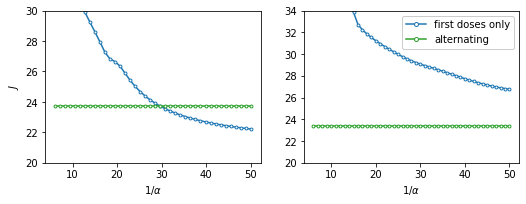

In [17]:
nRow=2
hspace=0.25
hRow=1.5

fig, ax = plt.subplots(1,2, figsize=(8.5,2.8))
plt.subplots_adjust(hspace=hspace)



plotOneLine(ax[0], resTotASZ[:, 0, 2], x=1/alphasASZ, c="C0", label="first doses only")
plotOneLine(ax[0], resTotASZ[:, 2, 2], x=1/alphasASZ, c="C2", label="alternating")

plotOneLine(ax[1], resTotPFZ[:, 0, 2], x=1/alphasPFZ, c="C0", label="first doses only")
plotOneLine(ax[1], resTotPFZ[:, 2, 2], x=1/alphasPFZ, c="C2", label="alternating")

ax[1].legend(facecolor='white', framealpha=1)
ax[0].set_ylabel(r"$J$")
ax[0].set_xlabel(r"$1/\alpha$")
ax[1].set_xlabel(r"$1/\alpha$")
ax[0].set_ylim(20, 30)
ax[1].set_ylim(20, 34)

plt.savefig("./FIG/varingAlpha.pdf", pad_inches=0.5, bbox_inches="tight")

# Inspect no contol evolution

max H: 37383.230857861236
max S: 59291139.09521809
max R: 2890130.8129477305
max D: 67541.6889249963
max I: 740513.4676545435


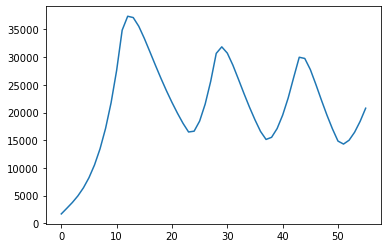

In [46]:
par = parameters(parCalibration)
getData(runNoControlFromSept(par, Dw="2w", steps=56))[0].H.plot()
print(f"max H: {getData(runNoControlFromSept(par))[0].H.max()}")
print(f"max S: {getData(runNoControlFromSept(par))[0].S.max()}")
print(f"max R: {getData(runNoControlFromSept(par))[0].R.max()}")
print(f"max D: {getData(runNoControlFromSept(par))[0].D.max()}")
print(f"max I: {getData(runNoControlFromSept(par))[0].I.max()}")

In [10]:
#S I R H D beta F1 F2 F3 W V rema
getX0At2712()

array([5.59076618e+07, 4.95479119e+05, 2.89013081e+06, 3.33936079e+04,
       6.75416889e+04, 4.56860011e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])